# Universal Differential Equation for a 2D PDE heat equation

In [1]:
using Pkg; Pkg.activate("../../."); Pkg.instantiate()
using Plots; gr()
using Statistics
using LinearAlgebra
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio

  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`


### Parameter declaration

In [2]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.1
t₁ = 5

#D₀ = 1
tolnl = 1e-4
itMax = 20
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1;

ref_steps = [1.5, 3.5] # intermediate time steps to be saved for the loss function

2-element Vector{Float64}:
 1.5
 3.5

In [3]:
function heatflow(T, fD::Function, p, tol=1e-4)
   
    Δx, Δy, Δt, t₁, ref_steps = p
    
    total_iter = 0
    t = 0
    step_idx = 1
    T_steps = []
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = fD(t)  # compute the diffusivity at each time
            # if iter == 1
            #     println("current D: ", D)
            # end
            
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end

        # We store the temperature matrix for the required time steps
        if(step_idx <= length(ref_steps))
            if(t >= ref_steps[step_idx])
                push!(T_steps, T)
                step_idx += 1
            end
        end
        
        t += Δt
        
    end

    # We always store the final time step
    push!(T_steps, T)
    
    return T_steps
    
end

heatflow (generic function with 2 methods)

In [4]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p
    
    #dTdx = diff(S, dims=1) / Δx
    #dTdy = diff(S, dims=2) / Δy

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

## Creating a reference dataset with a fake law

Let's assume that $D$ is a function of time

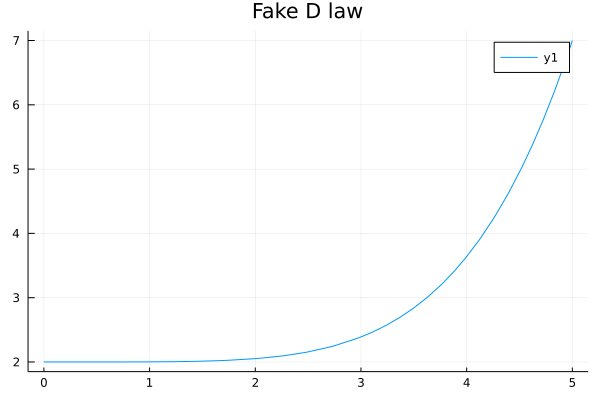

In [5]:
D_max = 10
D_min = 0

fakeD(t) = 1 * (2 + t^5 / t₁^4)

plot(fakeD, 0, t₁, title="Fake D law")

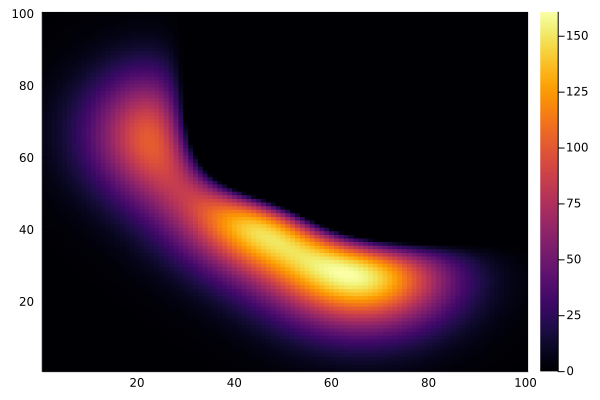

In [6]:
function truncated_gaussian(i₀, j₀, off) 
    
    M = [ 250 * exp( - ( (i - i₀)^2 + (j - j₀)^2 ) / 300 ) - off for i in 1:nx, j in 1:ny ]
    max.(0., M)
    
end

#T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

#T₀ = [ -(i - nx/2)^2 - (j - ny/.6)^2 + 40000 for i in 1:nx, j in 1:ny ]
#T₀ = max.(0., T₀)

T₀ = 1.5 * truncated_gaussian(nx/2, ny/2, 0) + 
     1 * truncated_gaussian(nx/3, ny/1.5, 0) +
     1 * truncated_gaussian(nx/1.5, ny/3, 0) - 
     4 * truncated_gaussian(nx/1.5, ny/2, 0) - 
     2 * truncated_gaussian(nx/2, ny/1.5, 0)

T₀ = max.(0., T₀)

heatmap(T₀, clim=(0, maximum(T₀)))

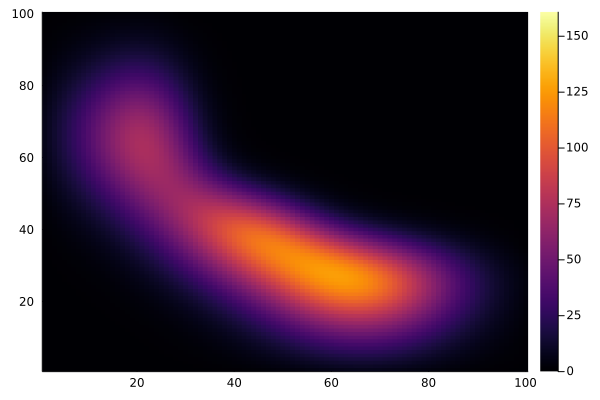

In [7]:
p = (Δx, Δy, Δt, t₁, ref_steps)

T₁ = copy(T₀)
T_steps_ref = heatflow(T₁, fakeD, p, 1e-2)
T₁ = T_steps_ref[end]

heatmap(T₁, clim=(0, maximum(T₀)))

In [8]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

10.095895612117783

## Using a neural network to learn D

Now, let's try to reproduce `fakeD()` with a NN.

In [9]:
function heatflow_NN(T, uD, p, tol=1e-4)
   
    Δx, Δy, Δt, t₁, ref_steps = p
    
    total_iter = 0
    t = 0
    step_idx = 1
    T_steps = Zygote.Buffer([])
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = uD([t]')[1]  # compute the diffusivity at each time
            #println(D)
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end

        # We store the temperature matrix for the required time steps
        if(step_idx <= length(ref_steps))
            if(t >= ref_steps[step_idx])
                push!(T_steps, T)
                step_idx += 1
            end
        end
        
        t += Δt
        
    end

    # We always store the final time step
    push!(T_steps, T)
    
    return T_steps
    
end

heatflow_NN (generic function with 2 methods)

In [10]:
sqnorm(x) = sum(abs2, x)

function loss(T, UD, p, λ=1)

    T_steps = heatflow_NN(T, UD, p)
    l_cost = 0
    for (i, T) in enumerate(T_steps)
        l_cost += sqrt(Flux.Losses.mse(T, T_steps_ref[i]; agg=mean))
    end
    l_cost /= length(T_steps)
    #l_reg  = sum(sqnorm, ps)

    return l_cost #+ λ * l_reg
end

loss (generic function with 2 methods)

In [11]:
# Patch suggested by Michael Abbott needed in order to correctly retrieve gradients
Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

leakyrelu(x, a=0.01) = max(a*x, x)
relu(x) = max(0, x)
sigmoid_D(x) = .5 + 10 / ( 1 + exp(-x) ) 

function train(loss, p)

    # UD = Chain(
    #     Dense(1,10, initb=Flux.glorot_normal), 
    #     BatchNorm(10, ),
    #     Dense(10, 5, x->tanh.(x), initb =Flux.glorot_normal), 
    #     BatchNorm(5, ),
    #     Dense(5, 5, x->tanh.(x), initb=Flux.glorot_normal),
    #     BatchNorm(5, ),
    #     Dense(5,1, relu, initb = Flux.glorot_normal) 
    # )


    # UD = Chain(
    #     Dense(1,10, initb=Flux.glorot_normal), 
    #     Dense(10, 5, leakyrelu, initb =Flux.glorot_normal), 
    #     Dense(5, 5, leakyrelu, initb=Flux.glorot_normal),
    #     Dense(5,1) 
    # )
    
    UD = Chain(
       Dense(1,5), 
       Dense(5, 10, x->tanh.(x), initb=Flux.glorot_normal),
       Dense(10, 5, x->tanh.(x), initb=Flux.glorot_normal),
       Dense(5, 1)
    )
    
    # opt = ADAM(1.0e-3)
    opt = RMSProp(0.01)
    #opt = Descent(0.1)
    
    losses = []
    θ = Flux.params(UD)
    @epochs 30 hybrid_train!(loss, UD, θ, p, opt, losses)
    
    return UD, θ, losses
    
end

function hybrid_train!(loss, UD, θ, p, opt, losses)
    
    T = T₀
    loss_uD, back_uD = Zygote.pullback(() -> loss(T, UD, p), θ)
    push!(losses, loss_uD)
    
    println("Current loss: ", loss_uD)
    # println("Current parameter:", θ)
    ∇_uD = back_uD(one(loss_uD))

    # for p in θ
    #    println("Gradients ∇_uD[p]: ", ∇_uD[p])
    # end
    
    #println("Values of NN: ", UD([0., .5, 1.]'))
    #all_times = LinRange(0, t₁, 1000)
    #plot(all_times, UD(all_times')')

    # Zygote.ignore() do
    #     all_times = LinRange(0, t₁, 1000)
    #     println("UD(all_times')': ",  UD(all_times')')
    #     plot(all_times, UD(all_times')', title="Simulated D values by the NN", yaxis="Diffusivity (D)", xaxis="Time", label="NN")
    #     display(plot!(fakeD, 0, t₁, label="fake"))
    # end
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
    
end

hybrid_train! (generic function with 1 method)

In [12]:
UD_trained, θ, losses = train(loss, p)

┌ Info: Epoch 1
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 7.175388366478018


┌ Info: Epoch 2
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 5.025393910238736


┌ Info: Epoch 3
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 3.589204346415258


┌ Info: Epoch 4
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 2.5955715160859585


┌ Info: Epoch 5
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 1.8181737689040895


┌ Info: Epoch 6
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 1.180715477658605


┌ Info: Epoch 7
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.6673607760962846


┌ Info: Epoch 8
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.42513374962406747


┌ Info: Epoch 9
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.4185870714860442


┌ Info: Epoch 10
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.4237521573834369


┌ Info: Epoch 11
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.4150846585150161


┌ Info: Epoch 12
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.4167349403351516


┌ Info: Epoch 13
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.4054145030267942


┌ Info: Epoch 14
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.41227525906077683


┌ Info: Epoch 15
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.3970731375708168


┌ Info: Epoch 16
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.4093917462016002


┌ Info: Epoch 17
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.38982706067040745


┌ Info: Epoch 18
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.40742920184830084


┌ Info: Epoch 19
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.3835922775631874


┌ Info: Epoch 20
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.40590075556419664


┌ Info: Epoch 21
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.3783250769345103


┌ Info: Epoch 22
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.40464274296252806


┌ Info: Epoch 23
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.37378950468795696


┌ Info: Epoch 24
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.4037138038847319


┌ Info: Epoch 25
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.3696378702508329


┌ Info: Epoch 26
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.40305926095144634


┌ Info: Epoch 27
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.36573655985375725


┌ Info: Epoch 28
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.40259580663021666


┌ Info: Epoch 29
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.3620412094871523


┌ Info: Epoch 30
└ @ Main /Users/Bolib001/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Current loss: 0.40226325329719037


(Chain(Dense(1, 5), Dense(5, 10, #37), Dense(10, 5, #38), Dense(5, 1)), Params([Float32[0.54031986; -0.58192325; … ; -0.18673654; 0.5969949], Float32[0.11699123, -0.005125467, 0.038660098, -0.05912034, 0.07425882], Float32[0.11230997 -0.147158 … -0.2382683 -0.4187686; 0.58588034 -0.42979798 … -0.3769206 0.63480693; … ; 0.25081852 -0.41257557 … -0.2136216 0.031106997; -0.27716106 0.54766494 … 0.7070797 -0.23713781], Float32[0.7341712, 0.75476134, -0.97219765, 0.6593062, 1.082248, -0.43044603, -0.16719224, -0.3017705, -0.14787744, 0.37659904], Float32[-0.0052893944 0.45089847 … 0.5171485 0.30805707; -0.40169725 -0.06873398 … 0.55682445 -0.381369; … ; 0.32149515 0.74823856 … -0.17883243 -0.6204124; -0.50753015 -0.27109763 … -0.001187584 0.6450776], Float32[0.61740947, 0.38953686, -0.9038636, -0.5611507, -0.40957677], Float32[0.29442194 0.88024867 … 0.5070922 -1.065906], Float32[0.15192807]]), Any[7.175388366478018, 5.025393910238736, 3.589204346415258, 2.5955715160859585, 1.81817376890408

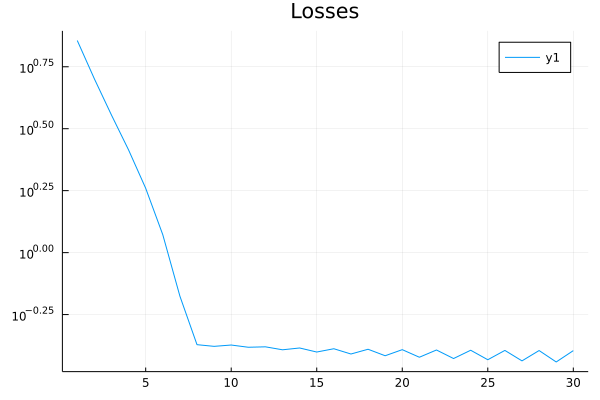

In [13]:
plot(losses, yaxis=:log, title="Losses")

In [14]:
println("θ: ", θ)
θ = Flux.params(UD_trained)
println("θ = Flux.params(UD_trained): ", θ)

θ: Params([Float32[0.54031986; -0.58192325; -0.31028986; -0.18673654; 0.5969949], Float32[0.11699123, -0.005125467, 0.038660098, -0.05912034, 0.07425882], Float32[0.11230997 -0.147158 -0.69205546 -0.2382683 -0.4187686; 0.58588034 -0.42979798 0.39543608 -0.3769206 0.63480693; 0.14207268 -0.35434127 0.673666 0.008961874 0.24288651; 0.25145078 0.438447 -0.32551417 0.019126996 -0.30572084; 0.5469515 -0.38061428 0.5986096 -0.43588227 -0.0013510181; -0.38833684 0.6800534 0.42278117 0.21325886 -0.44171226; -0.49123675 0.38638738 0.20233405 0.2583828 0.057031706; 0.69490993 -0.16325147 0.44201317 0.030758848 0.55211616; 0.25081852 -0.41257557 0.38476372 -0.2136216 0.031106997; -0.27716106 0.54766494 0.494712 0.7070797 -0.23713781], Float32[0.7341712, 0.75476134, -0.97219765, 0.6593062, 1.082248, -0.43044603, -0.16719224, -0.3017705, -0.14787744, 0.37659904], Float32[-0.0052893944 0.45089847 0.45772249 -0.017112037 0.13910337 0.11300789 0.39315152 -0.050085466 0.5171485 0.30805707; -0.40169725 

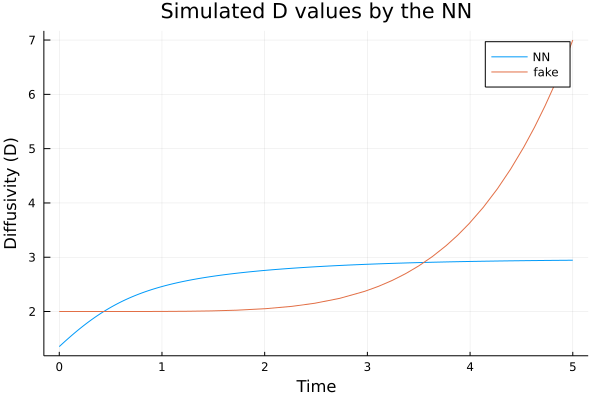

In [15]:
Flux.testmode!(UD_trained)
all_times = LinRange(0, t₁, 1000)
# println("UD(all_times')': ",  UD_trained(all_times')')
plot(all_times, UD_trained(all_times')', title="Simulated D values by the NN", yaxis="Diffusivity (D)", xaxis="Time", label="NN")
plot!(fakeD, 0, t₁, label="fake")